In [1]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories")

c:\Program Files\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import os
import numpy as np
from tqdm.auto import tqdm

def process(example):
    import tiktoken
    enc = tiktoken.get_encoding("gpt2")
    ids = enc.encode_ordinary(example['text'])
    out = {'ids': ids, 'len': len(ids)}
    return out

if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['text'],
        desc="tokenizing the splits",
        num_proc=8,
        )
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint16
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 1024

        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):

            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])

            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()

writing validation.bin: 100%|██████████| 1024/1024 [00:15<00:00, 66.95it/s]


In [5]:
def get_batch(split):
    
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
    

In [7]:
config = GPTConfig(
    vocab_size=50257,     
    block_size=128,       
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True
)

model = GPT(config)

In [8]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

In [9]:
import torch
from contextlib import nullcontext

learning_rate = 1e-4 
max_iters = 20000
warmup_steps = 1000 
min_lr = 5e-4 
eval_iters = 500 
batch_size = 32 
block_size = 128

gradient_accumulation_steps = 32

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' 

dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

In [10]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) 

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) 
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr)
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) 
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

C:\Users\acer\AppData\Local\Temp\ipykernel_5180\3302513730.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


In [11]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

model = model.to(device)

for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/20000 [00:00<?, ?it/s]C:\Users\acer\AppData\Roaming\Python\Python310\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  2%|▎         | 500/20000 [08:06<5:15:07,  1.03it/s]

Epoch 500: train loss 9.3905, val loss 9.4016
The current learning rate: 0.00007


  5%|▍         | 999/20000 [22:10<5:04:02,  1.04it/s]   C:\Users\acer\AppData\Roaming\Python\Python310\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  5%|▌         | 1000/20000 [22:11<5:04:36,  1.04it/s]

Epoch 1000: train loss 8.4392, val loss 8.4427
The current learning rate: 0.00010


  8%|▊         | 1500/20000 [36:14<4:59:11,  1.03it/s]   

Epoch 1500: train loss 7.4938, val loss 7.4970
The current learning rate: 0.00010


 10%|█         | 2000/20000 [50:17<4:49:33,  1.04it/s]   

Epoch 2000: train loss 6.6514, val loss 6.6498
The current learning rate: 0.00010


 12%|█▎        | 2500/20000 [1:04:18<4:31:50,  1.07it/s] 

Epoch 2500: train loss 5.9649, val loss 5.9648
The current learning rate: 0.00011


 15%|█▌        | 3000/20000 [1:18:16<4:32:41,  1.04it/s]  

Epoch 3000: train loss 5.4633, val loss 5.4614
The current learning rate: 0.00011


 18%|█▊        | 3500/20000 [1:32:13<4:24:46,  1.04it/s]   

Epoch 3500: train loss 5.0532, val loss 5.0481
The current learning rate: 0.00012


 20%|██        | 4000/20000 [1:46:11<5:30:25,  1.24s/it]   

Epoch 4000: train loss 4.7330, val loss 4.7347
The current learning rate: 0.00012


 22%|██▎       | 4500/20000 [2:00:07<4:08:33,  1.04it/s]   

Epoch 4500: train loss 4.4935, val loss 4.4984
The current learning rate: 0.00013


 25%|██▌       | 5000/20000 [2:14:04<3:59:48,  1.04it/s]   

Epoch 5000: train loss 4.2870, val loss 4.2828
The current learning rate: 0.00014


 28%|██▊       | 5500/20000 [2:27:58<3:51:35,  1.04it/s]   

Epoch 5500: train loss 4.1352, val loss 4.1420
The current learning rate: 0.00015


 30%|███       | 6000/20000 [2:41:53<3:42:42,  1.05it/s]   

Epoch 6000: train loss 3.9777, val loss 3.9799
The current learning rate: 0.00016


 32%|███▎      | 6500/20000 [2:55:49<3:29:48,  1.07it/s]   

Epoch 6500: train loss 3.8378, val loss 3.8387
The current learning rate: 0.00018


 35%|███▌      | 7000/20000 [3:09:49<3:30:14,  1.03it/s]  

Epoch 7000: train loss 3.7160, val loss 3.7170
The current learning rate: 0.00019


 38%|███▊      | 7500/20000 [3:23:54<3:20:01,  1.04it/s]   

Epoch 7500: train loss 3.6068, val loss 3.6102
The current learning rate: 0.00020


 40%|████      | 8000/20000 [3:38:04<4:09:32,  1.25s/it]   

Epoch 8000: train loss 3.4979, val loss 3.5042
The current learning rate: 0.00022


 42%|████▎     | 8500/20000 [3:51:58<3:02:54,  1.05it/s]   

Epoch 8500: train loss 3.4174, val loss 3.4247
The current learning rate: 0.00024


 45%|████▌     | 9000/20000 [4:05:53<2:54:36,  1.05it/s]   

Epoch 9000: train loss 3.3246, val loss 3.3263
The current learning rate: 0.00025


 48%|████▊     | 9500/20000 [4:20:03<2:47:43,  1.04it/s]   

Epoch 9500: train loss 3.2583, val loss 3.2573
The current learning rate: 0.00027


 50%|█████     | 10000/20000 [4:33:54<2:39:31,  1.04it/s]  

Epoch 10000: train loss 3.1782, val loss 3.1807
The current learning rate: 0.00028


 52%|█████▎    | 10500/20000 [4:47:59<2:30:24,  1.05it/s]   

Epoch 10500: train loss 3.1105, val loss 3.1174
The current learning rate: 0.00030


 55%|█████▌    | 11000/20000 [5:02:15<2:24:42,  1.04it/s]   

Epoch 11000: train loss 3.0577, val loss 3.0632
The current learning rate: 0.00032


 57%|█████▊    | 11500/20000 [5:16:21<2:16:07,  1.04it/s]   

Epoch 11500: train loss 2.9902, val loss 2.9946
The current learning rate: 0.00033


 60%|██████    | 12000/20000 [5:30:25<2:47:41,  1.26s/it]   

Epoch 12000: train loss 2.9357, val loss 2.9414
The current learning rate: 0.00035


 62%|██████▎   | 12500/20000 [5:44:27<1:58:35,  1.05it/s]   

Epoch 12500: train loss 2.8842, val loss 2.8897
The current learning rate: 0.00036


 65%|██████▌   | 13000/20000 [5:58:15<1:50:55,  1.05it/s]   

Epoch 13000: train loss 2.8354, val loss 2.8444
The current learning rate: 0.00038


 68%|██████▊   | 13500/20000 [6:12:04<1:43:55,  1.04it/s]   

Epoch 13500: train loss 2.7988, val loss 2.8045
The current learning rate: 0.00040


 70%|███████   | 14000/20000 [6:26:09<1:38:32,  1.01it/s]   

Epoch 14000: train loss 2.7591, val loss 2.7640
The current learning rate: 0.00041


 72%|███████▎  | 14500/20000 [6:40:01<1:24:46,  1.08it/s]   

Epoch 14500: train loss 2.7160, val loss 2.7175
The current learning rate: 0.00042


 75%|███████▌  | 15000/20000 [6:53:54<1:19:24,  1.05it/s]  

Epoch 15000: train loss 2.6829, val loss 2.6828
The current learning rate: 0.00044


 78%|███████▊  | 15500/20000 [7:06:23<1:01:21,  1.22it/s]   

Epoch 15500: train loss 2.6445, val loss 2.6403
The current learning rate: 0.00045


 80%|████████  | 16000/20000 [7:19:06<1:21:10,  1.22s/it]  

Epoch 16000: train loss 2.5948, val loss 2.6031
The current learning rate: 0.00046


 82%|████████▎ | 16500/20000 [7:31:44<48:02,  1.21it/s]    

Epoch 16500: train loss 2.5692, val loss 2.5778
The current learning rate: 0.00047


 85%|████████▌ | 17000/20000 [7:44:34<43:08,  1.16it/s]   

Epoch 17000: train loss 2.5332, val loss 2.5343
The current learning rate: 0.00048


 88%|████████▊ | 17500/20000 [7:57:33<36:22,  1.15it/s]   

Epoch 17500: train loss 2.5016, val loss 2.5039
The current learning rate: 0.00048


 90%|█████████ | 18000/20000 [8:10:03<30:41,  1.09it/s]   

Epoch 18000: train loss 2.4742, val loss 2.4838
The current learning rate: 0.00049


 92%|█████████▎| 18500/20000 [8:22:28<20:20,  1.23it/s]   

Epoch 18500: train loss 2.4540, val loss 2.4586
The current learning rate: 0.00049


 95%|█████████▌| 19000/20000 [8:34:55<13:41,  1.22it/s]   

Epoch 19000: train loss 2.4150, val loss 2.4259
The current learning rate: 0.00050


 98%|█████████▊| 19500/20000 [8:47:00<07:05,  1.18it/s]   

Epoch 19500: train loss 2.3963, val loss 2.4005
The current learning rate: 0.00050


100%|██████████| 20000/20000 [9:00:03<00:00,  1.62s/it]    


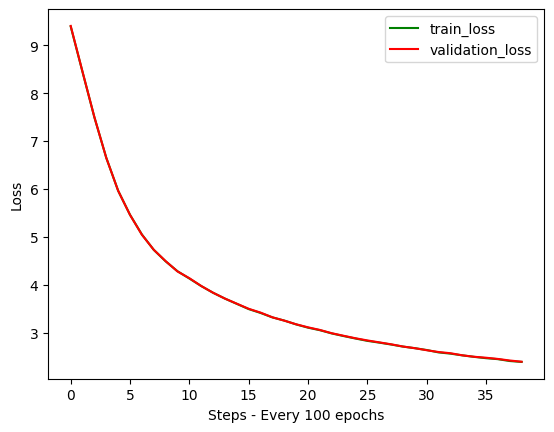

In [12]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [13]:
model = GPT(config)  
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


C:\Users\acer\AppData\Local\Temp\ipykernel_5180\2462269081.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path, map_l

<All keys matched successfully>

In [14]:
sentence = "Once upon a time there was a pumpkin."
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Once upon a time there was a pumpkin.

"Hello weighed sweet similar day," the creature said.

Kate looked up to the bee. It was so soft and powerful. She was happy!

The gorilla found a whole place with lots of things - from the other types of new stuff. Ruff inspired teddy bear had been full of bones and was able to play again.

The queen was content asGreat.

Kelly was amazed and had made the best risks, and she took well and smiled. The pig rubbing the power from the wall to do worrying.Once upon a time, there was a little boy named Jack. Jack loved to observe things his dream. Every morning, he would mix things. One day, his mother took him on something purple and wore a sparkly pattern in aped one by himself as a landscape.

He showed everyone all about it and everyone was very glad. It was a Nurse that soon. Jake was so excited to see it again, so the cabin was


In [16]:
sentence = "There was a girl"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

There was a girl. She was three years old. 

One day, she had a special song about taking her book from her room class. She was so excited about the pages. 

One day, she packed all the parts as she came in her computer. She went to the achieve her room and put it on her own and started to play with her bright jewelry. 

Millie's goal fit perfectly blinking loud, and hard work herselfrings was safe. But, she started to work too far away. She was so frightened and grabbed her ticket and ran back to her past her clothes and tried to come out, but was an amazing staff in the corner. 

At the end of the class, Paul put her hammer everywhere skills filled it and quickly open them zoomed out of the window. All could peeked out to the hut and over to see where there was a toy so many cane, and then he slowlyPokemon. It was herummy umbrellaened up as


In [17]:
sentence = "can he get the job?"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

can he get the job? 

Jackty smiled and said, "Why do you want to sell me something to me?".

Jack said, "Yes, we can buy lots of food!"Once upon a time there was a girl named Sarah. She was three years old and she loved the years old a very much. Every Wednesday Sarah would come to choose something special with her collection. 

Every day, Sarah would paint all by exploring the wild forest and people in the park. One day one day she noticed something in the park. Then she started to paint and draw in circles, just as importantlyly as she went. She's brother asked her if she could have better look. It was a special place to be seen. Sarah was so excited to do a celebration to see appeared on the scale and how she was wrapping out around the cool build.

The next day, Sarah took out his pictures and her some toast roles and put them at the lock. It was a harmless place to
